In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.core.display import display, HTML
import pandas as pd

import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, load_model
from keras import backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
display(HTML("<style>.container { width:90% !important; }</style>"))
plt.interactive(True)
%matplotlib inline
plt.rcParams['figure.figsize'] = [26, 6]

In [3]:
with open('../spectrograms.obj', 'rb') as specgram_file:
    specgrams = pickle.load(specgram_file)

print('Number of spectrograms: %s' % len(specgrams))

Number of spectrograms: 78


In [4]:
def max_multiple(number, base=4):
    return base * int(number/base)

min_x, min_y = min(specgram.shape[1] for specgram in specgrams), specgrams[0].shape[0]
min_x_mult, min_y_mult, min_x_50 = max_multiple(min_x), max_multiple(min_x), int(1.5*min_x)
print(min_x, min_y)
print(min_x_mult, min_y_mult, min_x_50)

68 64
68 68 102


In [5]:
# Reshape spectrograms by limiting number of columns to a max
reshape = []
for specgram in specgrams:
    reshape.append(specgram[:min_y_mult, :min_x_mult])
    if specgram.shape[1] > min_x_50:
        reshape.append(specgram[:min_y_mult, -min_x_mult:])  # if columns is > 1.5*min_size, append the last min_size columns

#Flip
augment = []
for specgram in reshape:
    augment.append(specgram)
    augment.append(np.flip(specgram, 0))  # flip rows / y axis
    augment.append(np.flip(specgram, 1))  # flip columns / x axis
    augment.append(np.flip(specgram, (0, 1)))  # flip rows and columns / x and y axis

print(len(augment))

384


In [6]:
# Obtain 3 dimensional shape
dim = augment[0].shape
if len(dim) < 3:
    dim += (1,)
print(dim)

(64, 68, 1)


In [7]:
# Split dataset between train and test
X_train, X_test = train_test_split(augment, test_size=0.25, shuffle=False)
print('Training samples: ' + str(len(X_train)))
print('Test samples: ' + str(len(X_test)))

Training samples: 288
Test samples: 96


In [8]:
# Add gaussian noise
noise_factor = 0.1

X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=dim[:2])

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

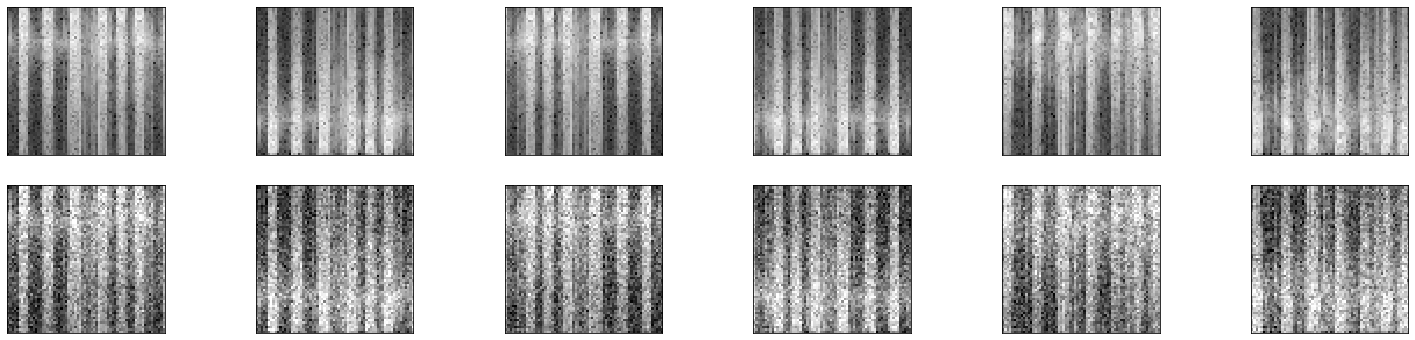

In [9]:
# Visualize original x noisy
n=6
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    ax.imshow(X_train[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i+n+1)
    ax.imshow(X_train_noisy[i], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [10]:
# Reshape images to be 3 dimensional
X_train = np.reshape(X_train, (len(X_train), dim[0], dim[1], dim[2]))
X_test = np.reshape(X_test, (len(X_test), dim[0], dim[1], dim[2]))

X_train_noisy = np.reshape(X_train_noisy, (len(X_train_noisy), dim[0], dim[1], dim[2]))
X_test_noisy = np.reshape(X_test_noisy, (len(X_test_noisy), dim[0], dim[1], dim[2]))

## Autoencoder Model

In [11]:
input_img = Input(shape=dim)

# encoder
code = Conv2D(16, kernel_size=(5, 5), padding='same', activation='relu')(input_img)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(4, kernel_size=(5, 5), padding='same', activation='relu')(code)
code = BatchNormalization()(code)
code = MaxPooling2D(pool_size=(2, 2))(code)
code = Conv2D(1, kernel_size=(5, 5), padding='same', activation='relu')(code)
bottleneck = Flatten()(code)

# decoder
x_hat = Reshape((16, 17, 1))(bottleneck)
x_hat = Conv2DTranspose(4, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(16, kernel_size=(5, 5), padding='same', activation='relu')(x_hat)
x_hat = BatchNormalization()(x_hat)
x_hat = UpSampling2D((2, 2))(x_hat)
x_hat = Conv2DTranspose(1, kernel_size=(5, 5), padding='same', activation='sigmoid')(x_hat)

autoencoder = Model(input_img, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 68, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 68, 16)        416       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 68, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 34, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 34, 4)         1604      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 34, 4)         16        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 17, 4)         0         
__________

In [12]:
# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=50),
             ModelCheckpoint(filepath='best_model_272.h5', monitor='val_loss', save_best_only=True)]

In [13]:
autoencoder.compile(loss='mean_squared_error', optimizer='adadelta')
# autoencoder.compile(loss='mse', optimizer='adam')

# tamanho do batch por iteracao
batch_size = 25

# número de épocas 
epochs = 250

# a variável history guarda os dados do processo de treinamento para posteriormente analisarmos
history = autoencoder.fit([X_train_noisy], [X_train],
                    batch_size=batch_size,
                    epochs=epochs,
                    shuffle=True,
                    callbacks=callbacks, # Early stopping
                    verbose=1,
                    validation_data=([X_test_noisy], [X_test]))

Train on 288 samples, validate on 96 samples
Epoch 1/250
288/288 [==============================] - 2s 8ms/step - loss: 0.0640 - val_loss: 0.0663
Epoch 2/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0333 - val_loss: 0.0500
Epoch 3/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0260 - val_loss: 0.0428
Epoch 4/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0222 - val_loss: 0.0388
Epoch 5/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0196 - val_loss: 0.0330
Epoch 6/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0188 - val_loss: 0.0292
Epoch 7/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0170 - val_loss: 0.0382
Epoch 8/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0169 - val_loss: 0.0254
Epoch 9/250
288/288 [==============================] - 2s 6ms/step - loss: 0.0160 - val_loss: 0.0255
Epoch 10/250
288/288 [========================

Epoch 81/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0110 - val_loss: 0.0232
Epoch 82/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0112 - val_loss: 0.0130
Epoch 83/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0111 - val_loss: 0.0225
Epoch 84/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 0.0125
Epoch 85/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0110 - val_loss: 0.0124
Epoch 86/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0129
Epoch 87/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0108 - val_loss: 0.0223
Epoch 88/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0113 - val_loss: 0.0236
Epoch 89/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0107 - val_loss: 0.0159
Epoch 90/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0110

288/288 [==============================] - 2s 7ms/step - loss: 0.0094 - val_loss: 0.0107
Epoch 240/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0113
Epoch 241/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 242/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0122
Epoch 243/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0108
Epoch 244/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0093 - val_loss: 0.0111
Epoch 245/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 246/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0095 - val_loss: 0.0117
Epoch 247/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0094 - val_loss: 0.0119
Epoch 248/250
288/288 [==============================] - 2s 7ms/step - loss: 0.0093 - v

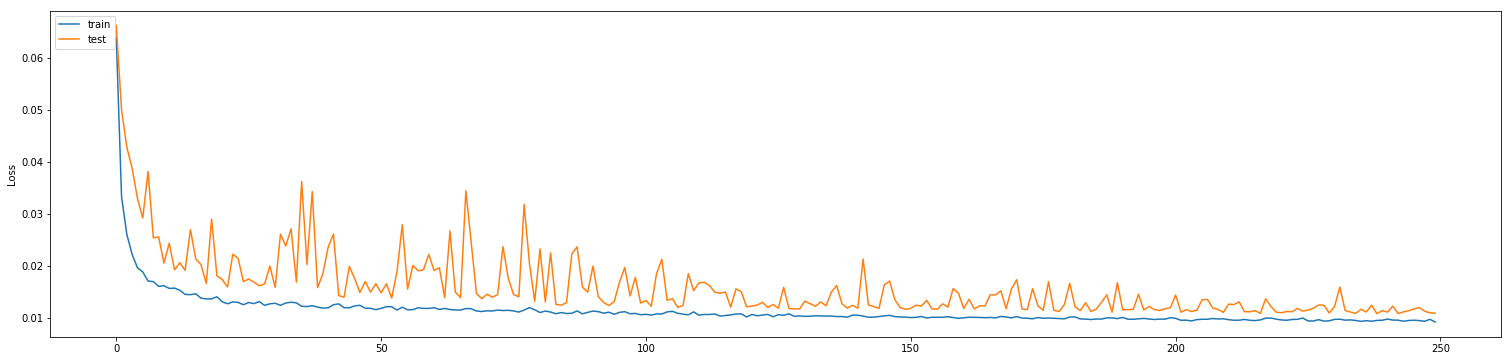

In [14]:
# utilizando o histórico: o gráfico da função de custo ao longo das épocas
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
# load best model
autoencoder = load_model('best_model_272.h5')

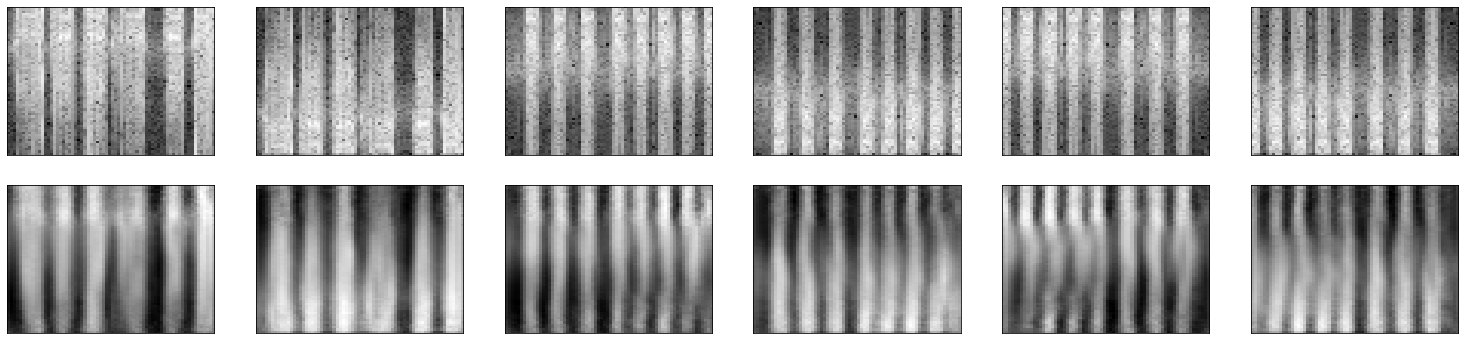

In [16]:
decoded_test = np.reshape(X_test, (len(X_test), dim[0], dim[1]))
decoded_predictions = autoencoder.predict([X_test])
decoded_predictions = np.reshape(decoded_predictions, (len(decoded_predictions), dim[0], dim[1]))

start, stop = 10, 16
for i, n in enumerate(range(start, stop), start=1):
    ax = plt.subplot(2, stop-start, i)
    plt.imshow(decoded_test[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, stop-start, i+stop-start)
    plt.imshow(decoded_predictions[n], cmap='gray', aspect='auto')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()